In [1]:
import json
import numpy as np
import random
import nltk
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, Bidirectional,
    Dense, Dropout, SpatialDropout1D
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split

print("Imports loaded successfully")

import tensorflow as tf

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

Imports loaded successfully


In [2]:
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

with open("intents.json") as f:
    data = json.load(f)

print("Loaded intents:", len(data["intents"]))


Loaded intents: 80


[nltk_data] Downloading package punkt to /Users/atulkumar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/atulkumar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
words = []
classes = []
sentences = []
labels = []

for intent in data["intents"]:
    for pattern in intent["patterns"]:
        tokens = nltk.word_tokenize(pattern.lower())
        words.extend(tokens)
        sentences.append(pattern)
        labels.append(intent["tag"])
    
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

print("Unique classes:", len(classes))


Unique classes: 80


In [4]:
ignore_chars = ["?", "!", ".", ","]

words = [
    lemmatizer.lemmatize(w.lower())
    for w in words if w not in ignore_chars
]

words = sorted(set(words))
classes = sorted(set(classes))

print("Final vocabulary size:", len(words))


Final vocabulary size: 295


In [5]:
def synonym_augment(sentence, p=0.3):
    tokens = nltk.word_tokenize(sentence)
    new_tokens = []
    for w in tokens:
        if random.random() < p:
            syns = wordnet.synsets(w)
            if syns:
                lemmas = syns[0].lemma_names()
                if lemmas:
                    new_tokens.append(lemmas[0].replace("_", " "))
                else:
                    new_tokens.append(w)
            else:
                new_tokens.append(w)
        else:
            new_tokens.append(w)
    return " ".join(new_tokens)

aug_sentences = []
aug_labels = []

for sent, label in zip(sentences, labels):
    # original
    aug_sentences.append(sent)
    aug_labels.append(label)

    # duplicate rare classes
    if labels.count(label) < 5:
        aug_sentences.append(sent)
        aug_labels.append(label)

    # synonym augmentation
    aug_sentences.append(synonym_augment(sent))
    aug_labels.append(label)

print("Augmented dataset size:", len(aug_sentences))


Augmented dataset size: 584


In [6]:
vocab_size = 3000
max_len = 25

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(aug_sentences)


sequences = tokenizer.texts_to_sequences(aug_sentences)
padded = pad_sequences(sequences, maxlen=max_len, padding="post")

label_to_id = {c: i for i, c in enumerate(classes)}

    
y = np.array([label_to_id[l] for l in aug_labels])
y = to_categorical(y, num_classes=len(classes))

X_train, X_val, y_train, y_val = train_test_split(
    padded, y, test_size=0.2,
    random_state=42, stratify=y
)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)


Train size: (467, 25)
Validation size: (117, 25)


In [7]:
model = Sequential()

model.add(Embedding(vocab_size, 128))
model.add(SpatialDropout1D(0.2))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(len(classes), activation="softmax"))

model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
early_stopping = EarlyStopping(
    patience=7,
    monitor='val_loss',
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    factor=0.5,
    patience=3,
    monitor='val_loss'
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

print("Training complete")


Epoch 1/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.0214 - loss: 4.3590 - val_accuracy: 0.0342 - val_loss: 4.3015 - learning_rate: 0.0010
Epoch 2/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.0150 - loss: 4.2840 - val_accuracy: 0.0427 - val_loss: 4.2341 - learning_rate: 0.0010
Epoch 3/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.0407 - loss: 4.1996 - val_accuracy: 0.0427 - val_loss: 4.1255 - learning_rate: 0.0010
Epoch 4/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.0428 - loss: 4.0649 - val_accuracy: 0.0598 - val_loss: 3.9862 - learning_rate: 0.0010
Epoch 5/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.0471 - loss: 3.9445 - val_accuracy: 0.0598 - val_loss: 3.8583 - learning_rate: 0.0010
Epoch 6/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0514 - loss: 3.8527 - val_accuracy: 0.0684 - val_loss: 3.7285 - learning_rate: 0.0010
Epoch 7/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.0578 - loss: 3.7093 - val_acc

In [ ]:
model.save('models/chat_model.keras')
import pickle, os
os.makedirs("pickle_files", exist_ok=True)
with open("pickle_files/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
with open("pickle_files/label_to_id.pkl", "wb") as f:
    pickle.dump(label_to_id, f)
with open("pickle_files/classes.pkl", "wb") as f: pickle.dump(classes, f)
with open("pickle_files/max_len.pkl", "wb") as f: pickle.dump(max_len, f)


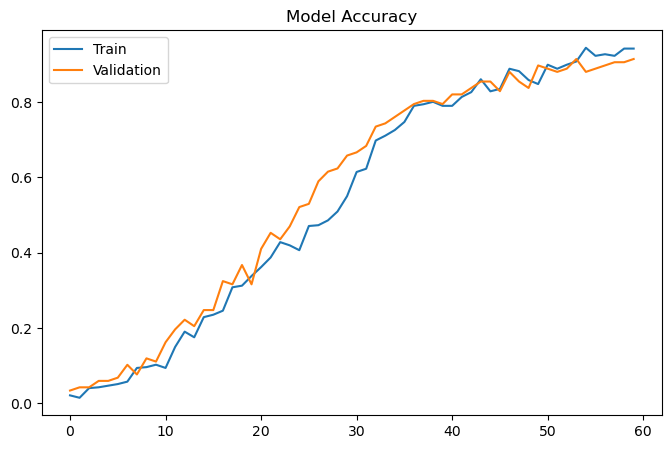

In [10]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Model Accuracy")
plt.legend()
plt.show()


In [11]:
def classify(sentence):
    seq = tokenizer.texts_to_sequences([sentence])
    pad = pad_sequences(seq, maxlen=max_len, padding="post")
    pred = model.predict(pad)[0]
    idx = np.argmax(pred)
    return classes[idx], pred[idx]

print(classify("I am feeling stressed"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
('worthless', np.float32(0.89210016))
